In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
os.listdir('bttai-ajl-2025')

['.DS_Store',
 'test',
 'test.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [4]:
import os

folder_path = 'bttai-ajl-2025'

# Check if the folder exists
if os.path.exists(folder_path):
  print(f"Folder '{folder_path}' found.")
else:
  print(f"Folder '{folder_path}' not found in your Google Drive.")


Folder 'bttai-ajl-2025' found.


In [5]:
# data paths
train_csv = os.path.join(folder_path, "train.csv")
test_csv = os.path.join(folder_path, "test.csv")
image_dir = os.path.join(folder_path, "train", "train")


# ***Exploratory Data Analysis***


*   Find any missing values in train & test
*   Visualize class distribution of skin condition


*   Visualize skin tone distribution
*   Find underrepresented classes to create more data







Missing values in train data:
md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
dtype: int64

Missing values in test data:
md5hash                   0
fitzpatrick_scale         0
fitzpatrick_centaur       0
qc                     1198
ddi_scale                 0
dtype: int64


/var/folders/g5/sjg42d957nv4zln7j0rk6wyr0000gn/T/ipykernel_2250/2882329988.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index, palette="viridis")


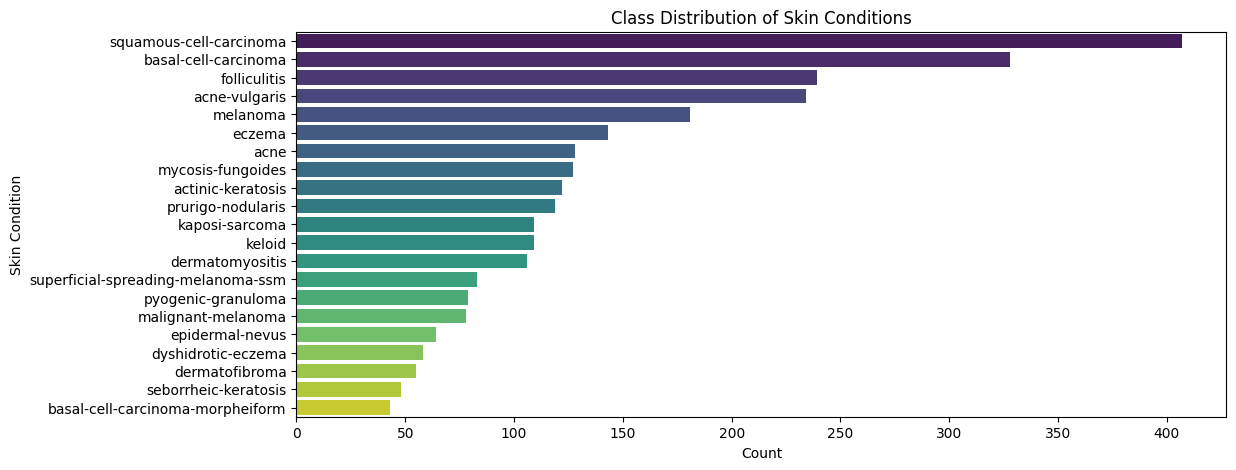

/var/folders/g5/sjg42d957nv4zln7j0rk6wyr0000gn/T/ipykernel_2250/2882329988.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df['fitzpatrick_scale'], palette="coolwarm")


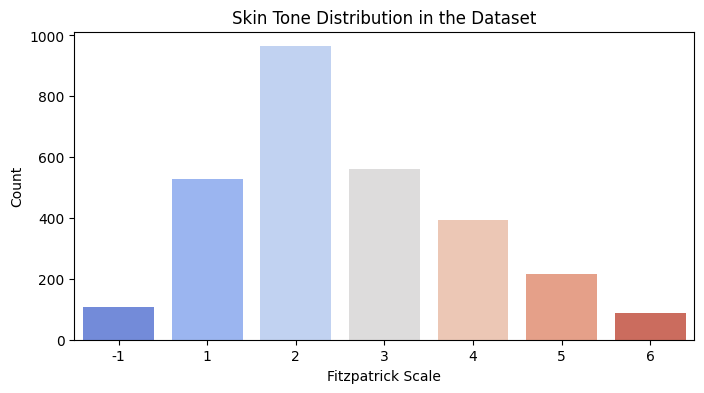

/var/folders/g5/sjg42d957nv4zln7j0rk6wyr0000gn/T/ipykernel_2250/2882329988.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dark_skin_df['fitzpatrick_scale'], palette="magma")


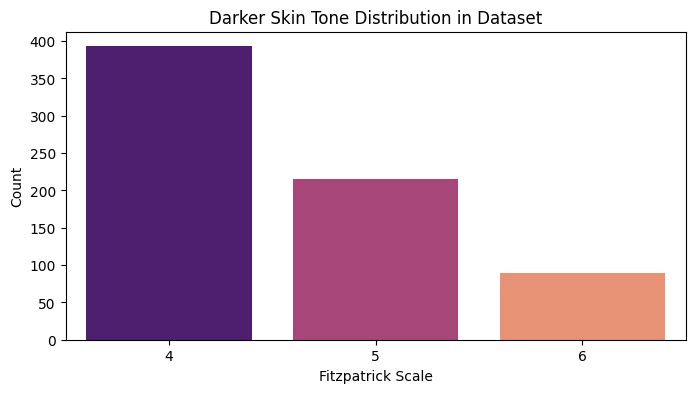

Underrepresented classes: Index(['seborrheic-keratosis', 'basal-cell-carcinoma-morpheiform'], dtype='object', name='label')


In [6]:
# Load CSV files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Display first few rows
train_df.head()

print("Missing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

plt.figure(figsize=(12, 5))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index, palette="viridis")
plt.title("Class Distribution of Skin Conditions")
plt.xlabel("Count")
plt.ylabel("Skin Condition")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=train_df['fitzpatrick_scale'], palette="coolwarm")
plt.title("Skin Tone Distribution in the Dataset")
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.show()

# explore darker skin images
dark_skin_df = train_df[train_df['fitzpatrick_scale'].isin([4, 5, 6])]

# Display the count of images in each darker skin tone category
plt.figure(figsize=(8, 4))
sns.countplot(x=dark_skin_df['fitzpatrick_scale'], palette="magma")
plt.title("Darker Skin Tone Distribution in Dataset")
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.show()


class_counts = train_df['label'].value_counts()
underrepresented_classes = class_counts[class_counts < 50].index  # Adjust threshold as needed
print("Underrepresented classes:", underrepresented_classes)



Data Training, Prepreoccesing and Loading


In [7]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']


# Check the first few rows to understand the structure
print(train_df.head())


# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [8]:
# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)


# **Data Augmentation**
Through this process we are adjusting the hyperprameters in datagen to create new images the goal is to try and make more dark skin images.

Where I am:


*   I was able to play around with image augmentation
*   I want to have this part try and expand on darker skin images if there are some if not then use light skin images and make those darker


*   Also check each skin condition and for each condition look at underrepresented skin tones and make more of those images since there are light skin tones that also have low numbers of images


*   Also some classes have low amounts of data in general increase those counts

1st code block was testing expanding the data for the skin conditions that had the least amount of photos but i also need to make sure that there are an equal distribution on skin tones

2nd code block is me attempting to expand the darker skin tone dataset but i need to first try and see if there are darker skin tones in the class instead of just grabbing any image and trying to augment that






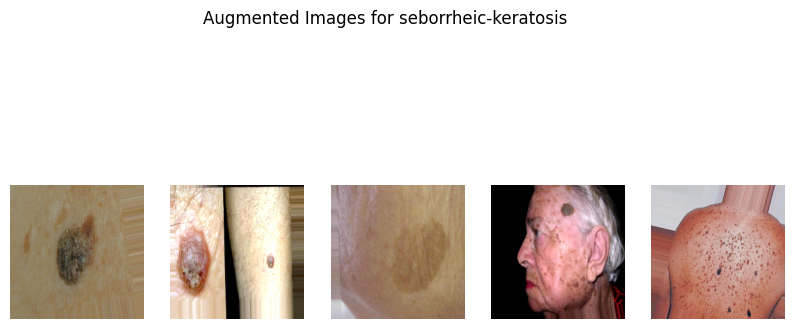

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

# Augment a class with low amounts of images
def augment_images(class_name, num_augmented=50):
    class_dir = os.path.join(image_dir, class_name)
    augmented_images = []

    for img_name in os.listdir(class_dir)[:num_augmented]:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to model input size
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        augmented = datagen.flow(img, batch_size=1)
        aug_img = next(augmented)[0].astype(np.uint8)

        augmented_images.append(aug_img)

    return augmented_images

# Show augmented images
augmented_images = augment_images(underrepresented_classes[0])

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle(f"Augmented Images for {underrepresented_classes[0]}")
plt.show()


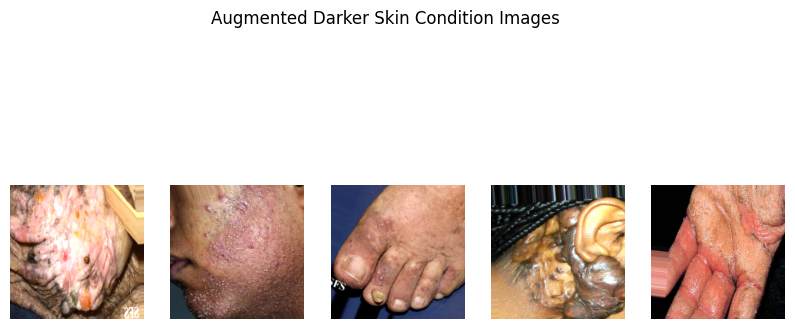

In [10]:
# Define augmentation strategy for darker skin tones
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[1.0, 1.5],
    zoom_range=0.3
)

def find_image_path(image_hash):
    """Search for an image file inside the train folder's subdirectories."""
    for condition in os.listdir(image_dir):  # Loop through subfolders
        condition_path = os.path.join(image_dir, condition)

        if os.path.isdir(condition_path):
            img_path = os.path.join(condition_path, image_hash + ".jpg")

            if os.path.exists(img_path):
                return img_path  # Return first match

    return None


# Function to augment darker skin images
def augment_dark_skin_images(df, num_augmented=50):
    augmented_images = []

    for _, row in df.iterrows():
        img_path = find_image_path(row['md5hash'])

        if img_path is None:
            print(f"Skipping missing file: {row['md5hash']}")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to match model input size
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Apply augmentation
        augmented = datagen.flow(img, batch_size=1)
        aug_img = next(augmented)[0].astype(np.uint8)

        augmented_images.append(aug_img)

    return augmented_images
# Generate augmented images
augmented_dark_skin_images = augment_dark_skin_images(dark_skin_df.sample(20))  # Sample 20 images

# Display some augmented images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_dark_skin_images[i])
    plt.axis('off')
plt.suptitle("Augmented Darker Skin Condition Images")
plt.show()


# **Modeling**

In [11]:
# Setting Up Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)


train_generator = datagen.flow_from_directory(
    "bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="training",
)

val_generator = datagen.flow_from_directory(
   "bttai-ajl-2025/train/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="validation",
)

Found 2300 images belonging to 21 classes.
Found 560 images belonging to 21 classes.


In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_df['label'].unique()), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)  # Smoother LR drop
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Allow more epochs

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Increased from 8
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping],
)

# Save the trained model
model.save("best_fine_tuned_model.h5")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/Users/shahed/Projects/Equitable AI for Dermatology - Team SPF/AJL-Team-SPF/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 531s 7s/step - accuracy: 0.0808 - loss: 3.0819 - val_accuracy: 0.2143 - val_loss: 2.6244 - learning_rate: 1.0000e-04
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 555s 8s/step - accuracy: 0.2284 - loss: 2.4446 - val_accuracy: 0.3286 - val_loss: 2.1746 - learning_rate: 1.0000e-04
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - accuracy: 0.3697 - loss: 1.8617 - val_accuracy: 0.3518 - val_loss: 2.1386 - learning_rate: 1.0000e-04
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step - accuracy: 0.4883 - loss: 1.4167 - val_accuracy: 0.4196 - val_loss: 1.8940 - learning_rate: 1.0000e-04
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.5982 - loss: 1.0541 - val_accuracy: 0.4482 - val_loss: 1.7937 - learning_rate: 1.0000e-04
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.6611 - loss: 0.8691 - val_accuracy: 0.4518 - val_loss: 1.8536 - learning_rate: 1.0000e-04
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 532s 7s/step - accuracy: 0.7269 

# **Evaluation**

18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Weighted F1 Score on Validation Set: 0.0631
              precision    recall  f1-score   support

           0       0.03      0.04      0.04        25
           1       0.06      0.04      0.05        46
           2       0.04      0.04      0.04        24
           3       0.09      0.08      0.08        65
           4       0.25      0.25      0.25         8
           5       0.07      0.09      0.08        11
           6       0.00      0.00      0.00        21
           7       0.25      0.09      0.13        11
           8       0.03      0.04      0.03        28
           9       0.00      0.00      0.00        12
          10       0.05      0.06      0.06        47
          11       0.05      0.05      0.05        21
          12       0.10      0.10      0.10        21
          13       0.00      0.00      0.00        15
          14       0.06      0.06      0.06        36
          15       0.09      0.08      0.09        2

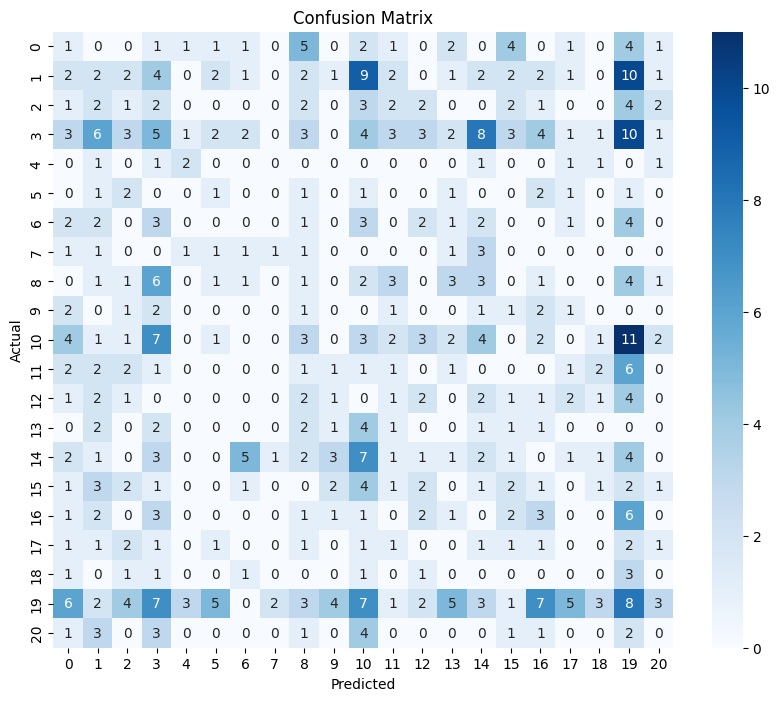

In [13]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict on validation set
val_predictions = model.predict(val_generator)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Get actual labels from validation set
actual_val_labels = val_generator.classes  # Actual labels in order

# Compute weighted F1-score
f1 = f1_score(actual_val_labels, val_predicted_labels, average='weighted')
print(f"Weighted F1 Score on Validation Set: {f1:.4f}")

# Print detailed classification report
print(classification_report(actual_val_labels, val_predicted_labels))

# Confusion matrix visualization
conf_matrix = confusion_matrix(actual_val_labels, val_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
test_image_dir = "bttai-ajl-2025/test/test"

In [15]:
# Check if the directory exists and contains images
if not os.path.exists(test_image_dir):
	raise ValueError(f"Directory {test_image_dir} does not exist.")
if len(os.listdir(test_image_dir)) == 0:
	raise ValueError(f"Directory {test_image_dir} is empty.")

# Ensure the test generator is properly initialized
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
	dataframe=test_df,
	directory=test_image_dir,
	x_col="md5hash",  # This is the file name
	y_col=None,  # No labels in test set
	target_size=(224, 224),
	batch_size=32,
	class_mode=None,
	shuffle=False
)

# Predict on test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert numerical predictions back to class names
test_df["label"] = label_encoder.inverse_transform(test_predicted_labels)


Found 1227 validated image filenames.


/Users/shahed/Projects/Equitable AI for Dermatology - Team SPF/AJL-Team-SPF/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


In [16]:
# Ensure the 'label' column exists in test_df
if 'label' not in test_df.columns:
	test_df['label'] = label_encoder.inverse_transform(test_predicted_labels)

submission = test_df[["md5hash", "label"]]
submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')
submission.to_csv("submission.csv", index=False)

print("Submission file saved: submission.csv")

Submission file saved: submission.csv


/var/folders/g5/sjg42d957nv4zln7j0rk6wyr0000gn/T/ipykernel_2250/4268176682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')
